In [ ]:
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1
!pip install torchscale
!pip install datasets, transformers
!pip install yfinance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %aimport Datasets
import datetime
import torch
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader
from Datasets import NumeraiData, NumeraiDataset
from Models import TabRetNet
from Trainer import ModelTrainer
from EvalModelForNumerai import EvaluateModelForNumerai

/home/charlo3d/miniconda3/envs/PytorchEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepares the data

In [6]:
## Numerai Data Variables
version  = "v4.2"
data_dir = "NumeraiData/" + version + "/"#If you change the dir, it will download the data once again

## Downloads the data and returns it as a pandas dataframe
numeraidata = NumeraiData(data_dir, version)
train_df, val_df, test_df, live_df, meta_model_df, validation_example_preds_df = numeraidata.load_data()

# Downsampling validation data if needed (devides the size of the data by k)
val_df_dwnspled = numeraidata.downsample_data_by_era(val_df, k=4)

2023-11-28 05:10:59,859 INFO numerapi.utils: target file already exists
2023-11-28 05:10:59,863 INFO numerapi.utils: download complete
2023-11-28 05:11:01,119 INFO numerapi.utils: target file already exists
2023-11-28 05:11:01,126 INFO numerapi.utils: download complete
2023-11-28 05:11:02,415 INFO numerapi.utils: target file already exists
2023-11-28 05:11:02,421 INFO numerapi.utils: download complete
2023-11-28 05:11:03,878 INFO numerapi.utils: target file already exists
2023-11-28 05:11:03,883 INFO numerapi.utils: download complete
2023-11-28 05:11:05,205 INFO numerapi.utils: target file already exists
2023-11-28 05:11:05,210 INFO numerapi.utils: download complete
2023-11-28 05:11:06,596 INFO numerapi.utils: target file already exists
2023-11-28 05:11:06,600 INFO numerapi.utils: download complete


: 

In [5]:
## Training and environment variables
EPOCHS = 10
PADDING_VALUE = -1
LR = 1e-4
batch_size = 1
max_seq_len = 6000
hop_len = 4200
add_padding=True
shuffle_intra_era = True
conf_path = 'Configs/retnet-small-8gbvram/config.json'
save_path = "Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/" #_MSEonly
save_best_model=True 
load_model_from_path=False
early_stopping_patience=3

# Model params
input_dim  = len(numeraidata.feature_cols)
output_dim = len(numeraidata.target_names)
embed_dropout_rate = 0.2
is_multiple_segments_input = True
is_bidir = False
max_num_era_in_seq = int(np.ceil(max_seq_len / np.min([train_df.groupby('era_int').era_int.count().min(), val_df.groupby('era_int').era_int.count().min(), test_df.groupby('era_int').era_int.count().min()]))) + 1#+1 because of the sliding window, it takes into account the case where we end an era and we begin one in the same sequence

# Loss params
lambda_mse  = 1.0
lambda_corr = 1.0
corr_on_main_targ = True

# Uses device available (GPU or CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

NameError: name 'train_df' is not defined

In [5]:
train_dataset_pt      = NumeraiDataset(train_df, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, hop_len=hop_len, shuffle_intra_era=shuffle_intra_era, add_padding=add_padding)
# Replace `val_df_dwnspled` by `val_df` if you want to use the full validation set
validation_dataset_pt = NumeraiDataset(val_df_dwnspled, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, hop_len=max_seq_len, shuffle_intra_era=shuffle_intra_era, add_padding=add_padding)
test_dataset_pt       = NumeraiDataset(test_df, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, hop_len=max_seq_len, shuffle_intra_era=shuffle_intra_era, add_padding=add_padding)

train_dl      = DataLoader(train_dataset_pt, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dl = DataLoader(validation_dataset_pt, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl       = DataLoader(test_dataset_pt, batch_size=batch_size, shuffle=False, num_workers=0)

#### tests

Just run these tests to convine yourself pearsonr works well with batches>1 !

```Python
x, y, mask, eras = next(iter(train_dl))
tabretnet.input_embed(x.float().to(device)) + tabretnet.segment_embeddings(eras.to(device).int()).squeeze(-2)

y[(mask.squeeze(-1)!=0)].shape

from Trainer import pearsonr

# y = torch.ones((10,6000,10))
# mask = mask.repeat(10,1,1)
pearsonr(y[(mask.squeeze(-1)!=0)], y[(mask.squeeze(-1)!=0)])
mask.sum()
y[(mask.squeeze(-1)!=0)].shape

```


## Loads the model

In [6]:
tabretnet = TabRetNet(config_path=conf_path, input_dim=input_dim, output_dim=output_dim, embed_dropout_rate=embed_dropout_rate, is_multiple_segments_input=is_multiple_segments_input, is_bidir=is_bidir, max_num_era_in_seq=max_num_era_in_seq)
print(tabretnet.to(device))

TabRetNet(
  (retnet): RetNetDecoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (output_projection): Linear(in_features=1024, out_features=50257, bias=False)
    (layernorm_embedding): RMSNorm()
    (layers): ModuleList(
      (0): DecoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (retention): MultiScaleRetention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1728, bias=False)
          (g_proj): Linear(in_features=1024, out_features=1728, bias=False)
          (out_proj): Linear(in_features=1728, out_features=1024, bias=False)
          (group_norm): RMSNorm()
        )
        (retention_layer_norm): RMSNorm()
        (ffn): GLU(
          (activation_dropout_module): Dropout(p=0.0, inplace=False)
          (dropout_module): Dropout(p=0.0, inplace=False)
          (fc1): Linear(in_

## Trains the model

In [7]:
trainer = ModelTrainer(tabretnet, train_dl, validation_dl, device, lr=LR, coef_mse=lambda_mse, coef_corr=lambda_corr, corr_on_main_targ=corr_on_main_targ, save_best_model=save_best_model, save_path=save_path, load_model_from_path=load_model_from_path)

Multiple .pt files found in Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/. Please choose one:
1: best_model.pt
2: model_last_iter.pt


Multiple metric files found in Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/. Please choose one:
1: Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/metrics_during_training_1.csv
2: Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/metrics_during_training_2.csv
Metric file found, best `val_loss` is 0.0276.
Loaded model from Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/best_model.pt


In [8]:
trainer.train_model(num_epochs=EPOCHS, early_stopping_patience=early_stopping_patience)


EPOCH: 1/10


  0%|          | 0/404 [00:00<?, ?it/s]

100%|██████████| 404/404 [1:36:31<00:00, 14.34s/it]


Train Loss: -0.0256 | Train Corr: 0.0730


100%|██████████| 109/109 [02:07<00:00,  1.17s/it]


Val Loss: 0.0282 | Val Corr: 0.0195

EPOCH: 2/10


100%|██████████| 404/404 [1:49:47<00:00, 16.30s/it]


Train Loss: -0.0319 | Train Corr: 0.0792


100%|██████████| 109/109 [01:13<00:00,  1.48it/s]


Val Loss: 0.0280 | Val Corr: 0.0196

EPOCH: 3/10


100%|██████████| 404/404 [1:25:17<00:00, 12.67s/it]


Train Loss: -0.0359 | Train Corr: 0.0830


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Val Loss: 0.0282 | Val Corr: 0.0194
Early stopping after 3 epochs

 Training finished!
Best Val Loss: 0.0276
Best Model saved at Results/Small_RetNet8gb_MultipleSegs_OneTargCorr/best_model.pt


TabRetNet(
  (retnet): RetNetDecoder(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (output_projection): Linear(in_features=1024, out_features=50257, bias=False)
    (layernorm_embedding): RMSNorm()
    (layers): ModuleList(
      (0): DecoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (retention): MultiScaleRetention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1728, bias=False)
          (g_proj): Linear(in_features=1024, out_features=1728, bias=False)
          (out_proj): Linear(in_features=1728, out_features=1024, bias=False)
          (group_norm): RMSNorm()
        )
        (retention_layer_norm): RMSNorm()
        (ffn): GLU(
          (activation_dropout_module): Dropout(p=0.0, inplace=False)
          (dropout_module): Dropout(p=0.0, inplace=False)
          (fc1): Linear(in_

## Tests the model

In [12]:
## Constant predictions => Corr is null. MSE is the variance of the target
test_df[numeraidata.target_names].describe()

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,target_bravo_v4_20,target_bravo_v4_60,target_charlie_v4_20,target_charlie_v4_60,target_delta_v4_20,target_delta_v4_60,target_echo_v4_20,target_echo_v4_60,target_jeremy_v4_20,target_jeremy_v4_60
count,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,...,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0,24074.0
mean,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
25%,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
50%,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
75%,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
max,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [13]:
## Data not trained on
nontrain_df         = pd.concat([val_df, test_df])
nontrain_dataset_pt = NumeraiDataset(nontrain_df, numeraidata.feature_cols, numeraidata.target_names, max_seq_len, PADDING_VALUE, multiple_eras_in_sequence=is_multiple_segments_input, add_padding=add_padding)
nontrain_dl         = DataLoader(nontrain_dataset_pt, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
nontrain_df[numeraidata.target_names].describe()

,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,target_tyler_v4_60,target_victor_v4_20,target_victor_v4_60,target_ralph_v4_20,target_ralph_v4_60,target_waldo_v4_20,...,target_bravo_v4_20,target_bravo_v4_60,target_charlie_v4_20,target_charlie_v4_60,target_delta_v4_20,target_delta_v4_60,target_echo_v4_20,target_echo_v4_60,target_jeremy_v4_20,target_jeremy_v4_60
count,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,...,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06,2.614655e+06
mean,5.000095e-01,4.999993e-01,5.000066e-01,4.999514e-01,4.999522e-01,4.999843e-01,4.999813e-01,5.000052e-01,4.999953e-01,5.000038e-01,...,4.999975e-01,4.999877e-01,5.000206e-01,5.000163e-01,4.999980e-01,5.000027e-01,5.000043e-01,5.000306e-01,5.000032e-01,4.999830e-01
std,2.220581e-01,2.225765e-01,2.208778e-01,2.226581e-01,2.209648e-01,2.225720e-01,2.208695e-01,2.223479e-01,2.206331e-01,2.221987e-01,...,2.225617e-01,2.208456e-01,2.217223e-01,2.200464e-01,2.225097e-01,2.208290e-01,2.223936e-01,2.207113e-01,2.219067e-01,2.190858e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
50%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
75%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [15]:
## Getting predictions from best model
# trainer.load_model(trainer.best_model)
test_predictions, test_loss, test_corr = trainer.ModelPredict(nontrain_dl, trainer.best_model)

  0%|          | 0/436 [00:00<?, ?it/s]

100%|██████████| 436/436 [03:53<00:00,  1.87it/s]

Loss: 0.0274 | Corr: 0.0198


In [16]:
## Parameters to evaluate the model
MY_MODEL_PREDICTION_NAME = 'prediction'
TARGET_NAME              = "target"
prediction_names = [MY_MODEL_PREDICTION_NAME, "example_preds", "numerai_meta_model"]
model_names      = ['My_Model', ' Example_Preds', 'Meta_Model']

nontrain_df[MY_MODEL_PREDICTION_NAME] = test_predictions[:,0]
nontrain_df["example_preds"] = validation_example_preds_df['prediction']
save_metric_df, save_plots = True, True

In [17]:
## Initializing evaluator
evalnumerai = EvaluateModelForNumerai(target_name=TARGET_NAME, mymodel_name=MY_MODEL_PREDICTION_NAME, save_folder_path=save_path, save_metric_df=save_metric_df, save_plots=save_plots)

/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jcl/miniconda3/envs/PytorchEnv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Index(['prediction2targ_model_corr', 'example_preds2targ_model_corr'], dtype='object')


,My_Model,Example_Preds
mean,0.019731,0.030927
min,-0.050409,-0.050413
max,0.082175,0.097112
std,0.021016,0.022587
sharpe,0.938856,1.369260
max_drawdown,0.169002,0.240087


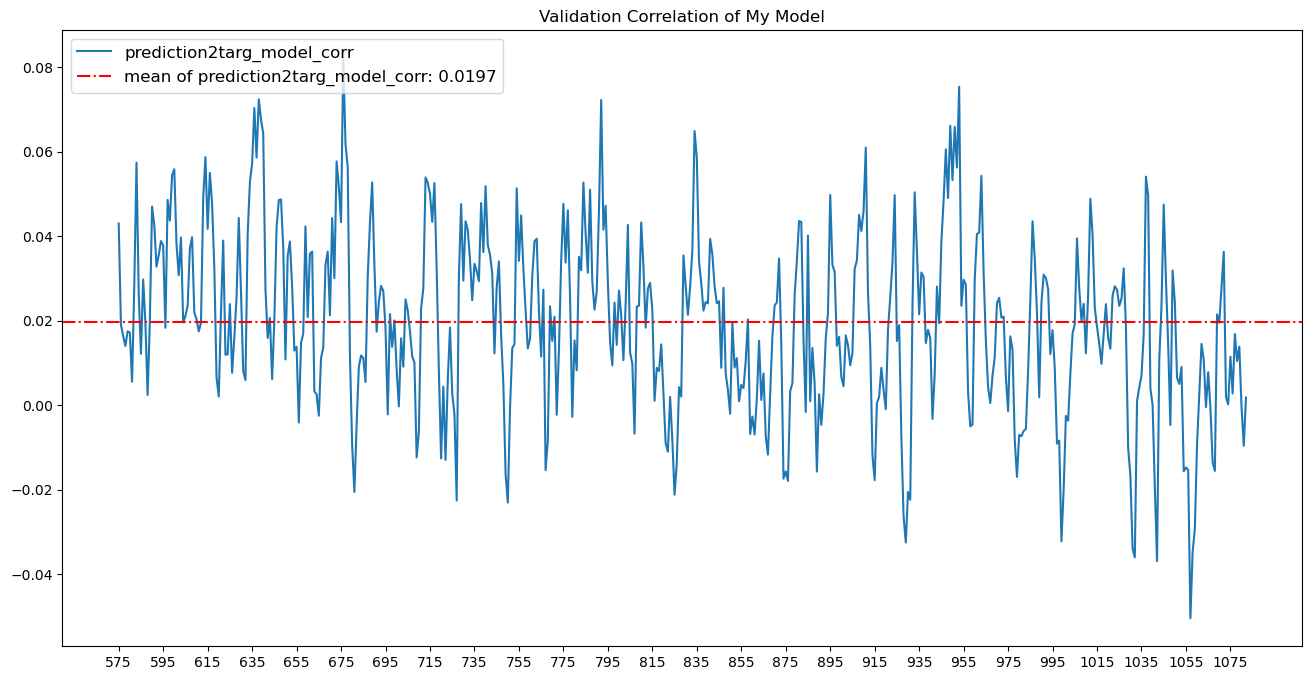

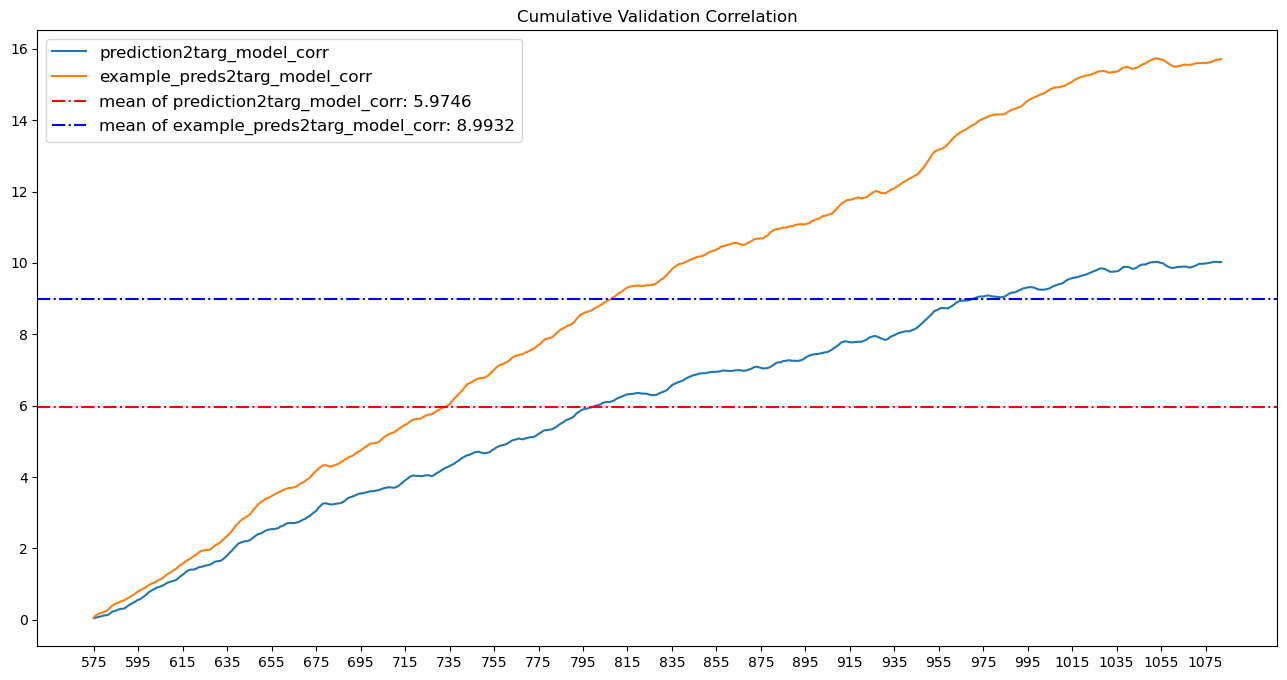

In [18]:
## Evaluating model performance on all val data for `example` and `my model`
evalnumerai.assess_model_performance(nontrain_df, prediction_names[:-1], model_names[:-1], add_means_to_plot=True, plot_cor_my_model=True, file_name_png="all_data_cumsum.png", file_name_csv="all_data_metrics_numerai.csv")

In [19]:
## Adding Meta Model to the mix
diagnosis = nontrain_df[["era_int", MY_MODEL_PREDICTION_NAME, TARGET_NAME, "example_preds"]].reset_index()

# Merge on right which is the meta model df
combined = pd.merge(
    diagnosis,
    meta_model_df,
    on=["id"],
    how="right"
).dropna(axis=0)

Index(['prediction2targ_model_corr', 'example_preds2targ_model_corr',
       'numerai_meta_model2targ_model_corr'],
      dtype='object')


,My_Model,Example_Preds,Meta_Model
mean,0.014131,0.024143,0.016004
min,-0.050409,-0.050413,-0.043135
max,0.075439,0.097112,0.081236
std,0.021980,0.025093,0.021791
sharpe,0.642912,0.962139,0.734418
max_drawdown,0.169002,0.240087,0.182124


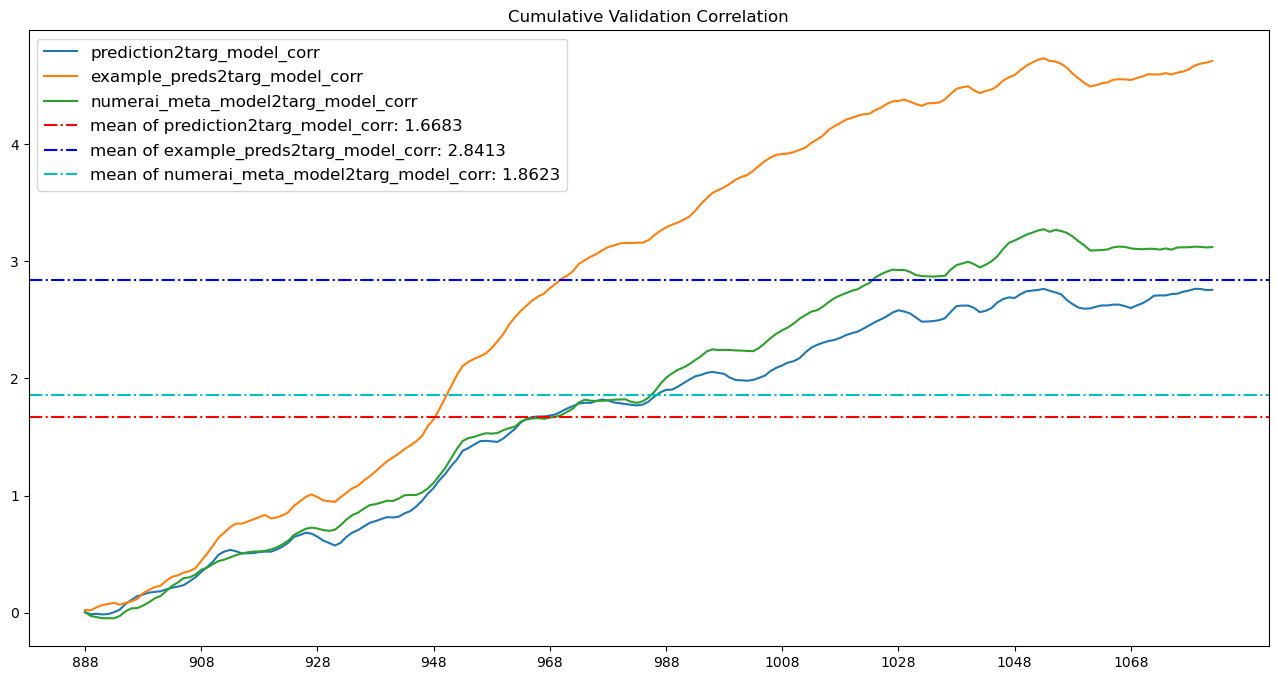

In [20]:
## Evaluating model performance on truncated data for `example`, `my model` and `meta model`
evalnumerai.assess_model_performance(combined, prediction_names, model_names, add_means_to_plot=True, plot_cor_my_model=False, file_name_png="all_models_cumsum.png", file_name_csv="all_models_metrics_numerai.csv")